## Calculate ENSO Skill as a Function of Initial Month vs. Lead Time

### In this example, we demonstrate: 
1. How to remotely access data from the North American Multi-model Ensemble (NMME) hindcast database and set it up to be used in `climpred`. 
2. How to calculate the Anomaly Correlation Coefficient (ACC) using monthly data
3. How to calculate and plot historical forecast skill of the Nino3.4 index as function of initialization month and lead time.

### The North American Multi-model Ensemble (NMME)

Further information on NMME is available from [Kirtman et al. 2014](https://journals.ametsoc.org/doi/full/10.1175/BAMS-D-12-00050.1) and the [NMME project website](https://www.cpc.ncep.noaa.gov/products/NMME/)

The NMME public database is hosted on the International Research Institute for Climate and Society (IRI) data server http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/

Since the NMME data server is accessed via this notebook, the time for the notebook to run may take a few minutes and vary depending on the speed that data is downloaded.

### Definitions

**Anomalies**
: Departure from normal, where normal is defined as the climatological value based on the average value for each month over all years.

**Nino3.4**
: An index used to represent the evolution of the El Nino-Southern Oscillation (ENSO). Calculated as the average sea surface temperature (SST) anomalies in the region 5S-5N; 190-240

In [1]:
import warnings

import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from climpred import HindcastEnsemble
import climpred

In [2]:
warnings.filterwarnings("ignore")

Function to set 360 calendar to 360_day calendar and decond cf times

In [3]:
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

Load the monthly sea surface temperature (SST) hindcast data for the NCEP-CFSv2 model from the NMME data server.  This is a large dataset, so we allow dask to chunk the data as it chooses. 

In [4]:
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/dods'
fcstds = decode_cf(xr.open_dataset(url, decode_times=False, 
                                   chunks={'S': 'auto', 'L': 'auto', 'M':'auto'}),'S')

fcstds

<xarray.Dataset>
Dimensions:  (L: 10, M: 24, S: 348, X: 360, Y: 181)
Coordinates:
  * S        (S) object 1982-01-01 00:00:00 ... 2010-12-01 00:00:00
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 20.0 21.0 22.0 23.0 24.0
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    sst      (S, L, M, Y, X) float32 dask.array<chunksize=(6, 5, 8, 181, 360), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL

The NMME data dimensions correspond to the following `climpred` dimension definitions: `X=lon`,`L=lead`,`Y=lat`,`M=member`, `S=init`.  We will rename the dimensions to their `climpred` names.

In [5]:
fcstds=fcstds.rename({'S': 'init','L': 'lead','M': 'member', 'X': 'lon', 'Y': 'lat'})

Let's make sure that the `lead` dimension is set properly for `climpred`.  NMME data stores `leads` as 0.5, 1.5, 2.5, etc, which correspond to 0, 1, 2, ... months since initialization. We will change the `lead` to be integers starting with zero.  `climpred` also requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years,seasons,months,weeks,pentads,days`.  For the monthly NMME data, the `lead` `units` are `months`.  

In [6]:
fcstds['lead']=(fcstds['lead']-0.5).astype('int')
fcstds['lead'].attrs={'units': 'months'}

Now we need to make sure that the `init` dimension is set properly for `climpred`.  For monthly data, the `init` dimension must be a `xr.cfdateTimeIndex` or a `pd.datetimeIndex`.  We convert the `init` values to `pd.datatimeIndex`.

In [7]:
fcstds['init']=pd.to_datetime(fcstds.init.values.astype(str))
fcstds['init']=pd.to_datetime(fcstds['init'].dt.strftime('%Y%m01 00:00'))

Next, we want to get the verification SST data from the data server

In [8]:
obsurl='http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.OIv2_SST/.sst/dods'
verifds = decode_cf(xr.open_dataset(obsurl, decode_times=False),'T')
verifds

<xarray.Dataset>
Dimensions:  (T: 405, X: 360, Y: 181)
Coordinates:
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * T        (T) object 1982-01-16 00:00:00 ... 2015-09-16 00:00:00
Data variables:
    sst      (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

Rename the dimensions to correspond to climpred dimensions

In [9]:
verifds=verifds.rename({'T': 'time','X': 'lon', 'Y': 'lat'})

Convert the `time` data to be of type `pd.datetimeIndex`

In [10]:
verifds['time']=pd.to_datetime(verifds.time.values.astype(str))
verifds['time']=pd.to_datetime(verifds['time'].dt.strftime('%Y%m01 00:00'))

Subset the data to 1982-2010

In [11]:
fcstds=fcstds.sel(init=slice('1982-01-01','2010-12-01'))
verifds=verifds.sel(time=slice('1982-01-01','2010-12-01'))

Calculate the Nino3.4 index for forecast and verification.

In [12]:
fcstnino34=fcstds.sel(lat=slice(-5,5),lon=slice(190,240)).mean(['lat','lon'])
verifnino34=verifds.sel(lat=slice(-5,5),lon=slice(190,240)).mean(['lat','lon'])

fcstclimo = fcstnino34.groupby('init.month').mean('init')
fcst = (fcstnino34.groupby('init.month') - fcstclimo)

verifclimo = verifnino34.groupby('time.month').mean('time')
verif = (verifnino34.groupby('time.month') - verifclimo)

Because will will calculate the anomaly correlation coefficient over all `time` for verification and `init` for the hindcasts, we need to rechunk the data so that these dimensions are in same chunk

In [13]:
fcst=fcst.chunk({'init':-1})
verif=verif.chunk({'time':-1})

Use the `climpred HindcastEnsemble` to calculate the anomaly correlation coefficient (ACC) as a function of initial month and `lead` 

In [14]:
skill=np.zeros((fcst['lead'].size, 12))
for im in tqdm(np.arange(0,12)):
    hindcast = HindcastEnsemble(fcst.sel(init=fcst['init.month']==im+1))
    hindcast = hindcast.add_observations(verif, 'observations')
    skillds = hindcast.verify(metric='acc')
    skill[:,im]=skillds['sst'].values

Plot the ACC as function of Initial Month and lead-time

Text(0, 0.5, 'Lead Time (Months)')

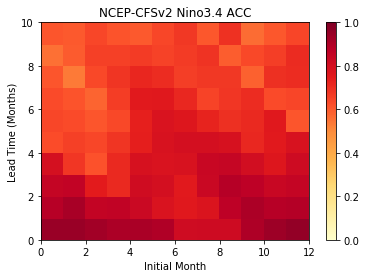

In [15]:
plt.pcolormesh(skill,cmap=plt.cm.YlOrRd,vmin=0.0,vmax=1.0)
plt.colorbar()
plt.title('NCEP-CFSv2 Nino3.4 ACC')
plt.xlabel('Initial Month')
plt.ylabel('Lead Time (Months)')

### References

1. Kirtman, B.P., D. Min, J.M. Infanti, J.L. Kinter, D.A. Paolino, Q. Zhang, H. van den Dool, S. Saha, M.P. Mendez, E. Becker, P. Peng, P. Tripp, J. Huang, D.G. DeWitt, M.K. Tippett, A.G. Barnston, S. Li, A. Rosati, S.D. Schubert, M. Rienecker, M. Suarez, Z.E. Li, J. Marshak, Y. Lim, J. Tribbia, K. Pegion, W.J. Merryfield, B. Denis, and E.F. Wood, 2014: The North American Multimodel Ensemble: Phase-1 Seasonal-to-Interannual Prediction; Phase-2 toward Developing Intraseasonal Prediction. Bull. Amer. Meteor. Soc., 95, 585–601, https://doi.org/10.1175/BAMS-D-12-00050.1